In [1]:
import pandas as pd
import pandas as pd, numpy as np
from pathlib import Path
import fsspec
import matplotlib.pyplot as plt

Question 1

In [2]:
def station_data(station_id):
    
    '''Receives a GHCN Station ID string and returns record daily max,
    average daily max, record daily min and average daily min for 
    the period 1991-2020'''
    
    begin_date = "1-Jan-1990"
    end_date = "31-Dec-2020"

    download_string = "s3://noaa-ghcn-pds/csv/by_station/" + str(station_id) + ".csv"
    df = pd.read_csv( 
                     download_string,
                     storage_options={"anon": True},  # passed to `s3fs.S3FileSystem`
                     dtype={'Q_FLAG': 'object', 'M_FLAG': 'object'},
                     parse_dates=['DATE']
                     ).set_index('DATE')
    
    # Filtering for date
    df = df[(df.index >= pd.to_datetime(begin_date)) & (df.index <= pd.to_datetime(end_date))]

    # Selecting only Minimum and Maximum temperature observations
    df_daily_min = df[(df['ELEMENT'] == 'TMIN')]
    df_daily_max = df[(df['ELEMENT'] == 'TMAX')]
    
    # Computing statistics for the temperature data.
    #
    # Data is provided to the tenths decimal place but does not include
    # the decimal, so you must divide by 10 to get the actual temp value
    min_min = df_daily_min.groupby(df_daily_min.index.dayofyear)['DATA_VALUE'].min()/10
    max_max = df_daily_max.groupby(df_daily_max.index.dayofyear)['DATA_VALUE'].max()/10
    min_average = df_daily_min.groupby(df_daily_min.index.dayofyear)['DATA_VALUE'].mean()/10
    max_average = df_daily_max.groupby(df_daily_max.index.dayofyear)['DATA_VALUE'].mean()/10

    result = pd.DataFrame({"record_min_temp": min_min, 
                           "average_min_temp": min_average, 
                           "average_max_temp": max_average,
                           "record_max_temp": max_max,
                           }
                           ) 
    result.index =  pd.date_range('2024', freq='D', periods=366).strftime("%m/%d")

    return result



In [3]:
#Station IDs for valid weather sites. 
#Selected from GHCNd inventory.

Patuxent_River_MD_stid = 'USC00186915'
Lovelaceville_KY_stid = 'USC00155067' 

df = station_data(Lovelaceville_KY_stid)

C:\Users\12ian\AppData\Local\Temp\ipykernel_36140\3498232738.py:11: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


In [4]:
df

,record_min_temp,average_min_temp,average_max_temp,record_max_temp
01/01,-16.7,-1.993333,8.053333,20.0
01/02,-17.8,-1.596774,7.451613,22.2
01/03,-18.9,-0.974194,7.900000,21.1
01/04,-14.4,-2.012903,8.632258,20.6
01/05,-15.6,-2.293548,7.409677,20.0
...,...,...,...,...
12/27,-12.8,-1.329032,9.277419,23.9
12/28,-11.1,-0.535484,9.551613,21.7
12/29,-12.2,-1.293548,8.151613,18.9
12/30,-13.3,-0.861290,8.112903,19.4


Question 2

In [5]:
def station_year(station_id: str, year: int):

    '''Receives a GHCN Station ID string and a year int and return
       the daily observed minimum and maximum temperatures for that
       year.'''

    download_string = "s3://noaa-ghcn-pds/csv/by_station/" + str(station_id) + ".csv"
    df = pd.read_csv( 
                     download_string,
                     storage_options={"anon": True},  # passed to `s3fs.S3FileSystem`
                     dtype={'Q_FLAG': 'object', 'M_FLAG': 'object'},
                     parse_dates=['DATE']
                     ).set_index('DATE')
    # filtering for the given year
    df = df[df.index.year == year]
    
    #selecting only temp min and max from the dataset.
    #
    # Data is provided to the tenths decimal place but does not include
    # the decimal, so you must divide by 10 to get the actual temp value
    df_daily_min = df[(df['ELEMENT'] == 'TMIN')]['DATA_VALUE']/10
    df_daily_max = df[(df['ELEMENT'] == 'TMAX')]['DATA_VALUE']/10

    result = pd.DataFrame({"daily min": df_daily_min, 
                           "daily max": df_daily_max, 
                           }
                           ) 
    
    return result

    
    

In [6]:
station_2000 = station_year(Lovelaceville_KY_stid, 2000)

C:\Users\12ian\AppData\Local\Temp\ipykernel_36140\3486194521.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


In [7]:
station_2000

,daily min,daily max
DATE,,
2000-01-01,1.7,18.3
2000-01-02,10.0,20.0
2000-01-03,11.7,21.1
2000-01-04,-1.1,15.6
2000-01-05,-2.8,3.3
...,...,...
2000-12-27,-6.1,0.0
2000-12-28,-10.0,-1.7
2000-12-29,-8.3,-3.3


Text(0.5, 1.0, 'Daily Temperature Range 1990-2020, Lovelaceville, KY')

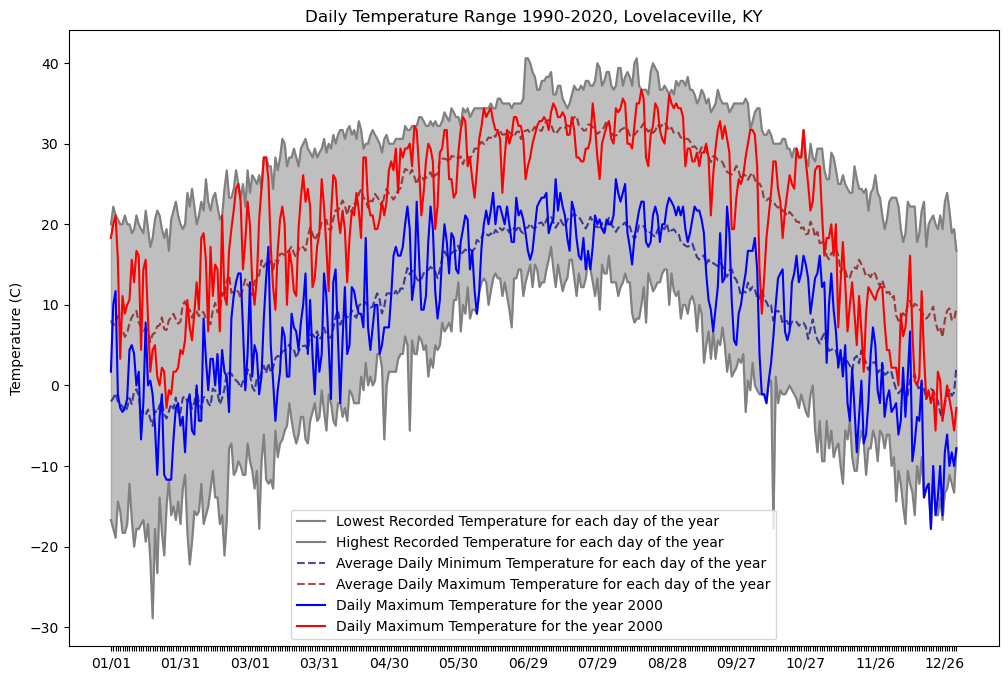

In [8]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (12,8))
label_freq = 30

ax.plot(df['record_min_temp'], 
        c = 'gray', 
        label = 'Lowest Recorded Temperature for each day of the year')

ax.plot(df['record_max_temp'], 
        c = 'gray', 
        label = 'Highest Recorded Temperature for each day of the year')

ax.plot(df['average_min_temp'], 
        c = 'darkblue', 
        alpha = 0.7, 
        linestyle = 'dashed', 
        label = 'Average Daily Minimum Temperature for each day of the year')

ax.plot(df['average_max_temp'], 
        c = 'darkred', 
        alpha = 0.7, 
        linestyle = 'dashed', 
        label = 'Average Daily Maximum Temperature for each day of the year')

ax.plot(station_2000.index.strftime('%m/%d'), 
        station_2000['daily min'], 
        c = 'blue',
        label = 'Daily Maximum Temperature for the year 2000')

ax.plot(station_2000.index.strftime('%m/%d'), 
        station_2000['daily max'], 
        c = 'red',
        label = 'Daily Maximum Temperature for the year 2000')

ax.fill_between(df.index, 
                df['record_min_temp'], 
                df['record_max_temp'], 
                color = 'gray', 
                alpha = 0.5)

ax.set_ylabel('Temperature (C)')
x_labels = ax.get_xticklabels()

ax.legend()

# the code below filters the visible x-labels to make it readable
for i, label in enumerate(x_labels):
    if i % label_freq != 0:
        label.set_visible(False)

ax.set_title('Daily Temperature Range 1990-2020, Lovelaceville, KY')